In [1]:
import logging
import warnings
from os.path import join

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from arviz import summary

from analysis import bayescorr, best
from analysis.utilities import makeDirIfNeeded
from plotting.plot_utils import *

In [2]:
#% Preparations and settings
warnings.filterwarnings("ignore")

logger = logging.getLogger("pymc3")
logger.setLevel(logging.ERROR)

# Random seed
SEED = 2078
np.random.seed(SEED)

# Plot settings
palette = [
    "slategray",
    "darksalmon",
    "mediumaquamarine",
    "indianred",
    "paleturquoise",
    "lightpink",
    "tan",
    "orchid",
]
matplotlib = set_mpl_defaults(matplotlib)

# MCMC settings (passed on to pm.sample)
sample_kwargs = {"cores": 1, "random_seed": SEED, "progressbar": False}

# Directories
RESULTS_DIR = join("..", "results")
OUTPUT_DIR = join("..", "results", "S_supplemental-qualitative-tests-of-gda")
makeDirIfNeeded(OUTPUT_DIR)

In [3]:
# Which models to include, and how to name them in the plots
hybrid = "sb_int-multiplicative_comp-vsmean_gbatt-false_gbalt-true_lk-free_inh-distance-dependent"
models = [
    "glickman1layer",
    "mdft",
    "gaze-baseline-dyn",
    "gaze-baseline-stat",
    "eu",
    hybrid,
]
model_labels = {
    "glickman1layer": "GLA",
    "mdft": "MDFT",
    "eu": "EU",
    "gaze-baseline-stat": "GB" + r"$_{stat}$",
    "gaze-baseline-dyn": "GB" + r"$_{dyn}$",
    hybrid: "Hybrid",
}

In [4]:
# Load trial data
trials = pd.read_csv(join(RESULTS_DIR, "0-clean_data", "trials_with-dwells.csv"))

# Load prediction dataframe (includes predictions of all models)
predictions = pd.read_csv(
    join(RESULTS_DIR, "3-behavioural-modeling", "predictions", "predictions_de1.csv")
)

# add predictions of hybrid switchboard model
predictions_sb = pd.read_csv(
    join(RESULTS_DIR, "4-switchboard", "predictions", "sb_predictions_de1.csv")
)
predictions_hybrid = predictions_sb.loc[predictions_sb["model"] == models[-1]]
predictions_hybrid = trials.merge(
    predictions_hybrid[["subject", "trial", "predicted_choice", "rep", "model"]],
    on=["subject", "trial"],
)

predictions = pd.concat([predictions, predictions_hybrid])

predictions["predicted_choice"] = np.array(["A", "B", "C"])[
    predictions["predicted_choice"]
]

## Add `predicted_choice_tcd` variable to predicted data
predictions["predicted_choice_tcd"] = np.where(
    pd.isnull(predictions["target"]),
    np.nan,
    np.where(
        predictions["predicted_choice"] == "C",
        "decoy",
        np.where(
            ((predictions["predicted_choice"] == "A") & (predictions["target"] == "A"))
            | (
                (predictions["predicted_choice"] == "B")
                & (predictions["target"] == "B")
            ),
            "target",
            "competitor",
        ),
    ),
)

In [5]:
def plot_dwell_adv(
    df, kind="bar", alternative="A", ax=None, color="C0", choicecol="choice", label=None
):
    """
    Make a plot of probability of choice, depending on binned dwell time advantage.
    """
    if ax is None:
        ax = plt.gca()

    # Compute means and sems
    df[f"{alternative}_chosen"] = df[choicecol] == alternative
    summary = (
        df.groupby(["subject", f"total_dwell_adv_{alternative}"])[
            f"{alternative}_chosen"
        ]
        .mean()
        .reset_index()
        .groupby(f"total_dwell_adv_{alternative}")[f"{alternative}_chosen"]
        .aggregate(["mean", "sem"])
    )
    x = np.arange(len(summary))
    if kind == "bar":
        ax.bar(x=x, height=summary["mean"], color=color, label=label)
        ax.vlines(
            x=x,
            ymin=summary["mean"] - summary["sem"],
            ymax=summary["mean"] + summary["sem"],
            color="black",
        )
    elif kind == "line":
        ax.plot(
            x,
            summary["mean"],
            "--o",
            color=color,
            markersize=3,
            markerfacecolor="none",
            label=label,
        )

    ax.set_xticks(x)
    ax.set_xticklabels(
        np.round([interval.mid for interval in summary.index], 2), rotation=45
    )
    ax.set_xlabel(f"Rel. dwell time advantage {alternative.capitalize()}")

    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.01, 0.25))
    ax.set_ylabel(f"P(Choose {alternative.capitalize()})")

    return ax, summary

In [6]:
# add dwell time advantage for each alternative
bins = np.arange(-0.35, 0.36, 0.1).round(2)

for i in ["A", "B", "C", "target", "competitor", "decoy"]:
    others = [j for j in ["A", "B", "C"] if j != i]
    for df in [trials, predictions]:
        adv_i = df[f"dwell_{i}"] - df[[f"dwell_{j}" for j in others]].mean(axis=1)
        df[f"total_dwell_adv_{i}"] = pd.cut(adv_i, bins=bins)

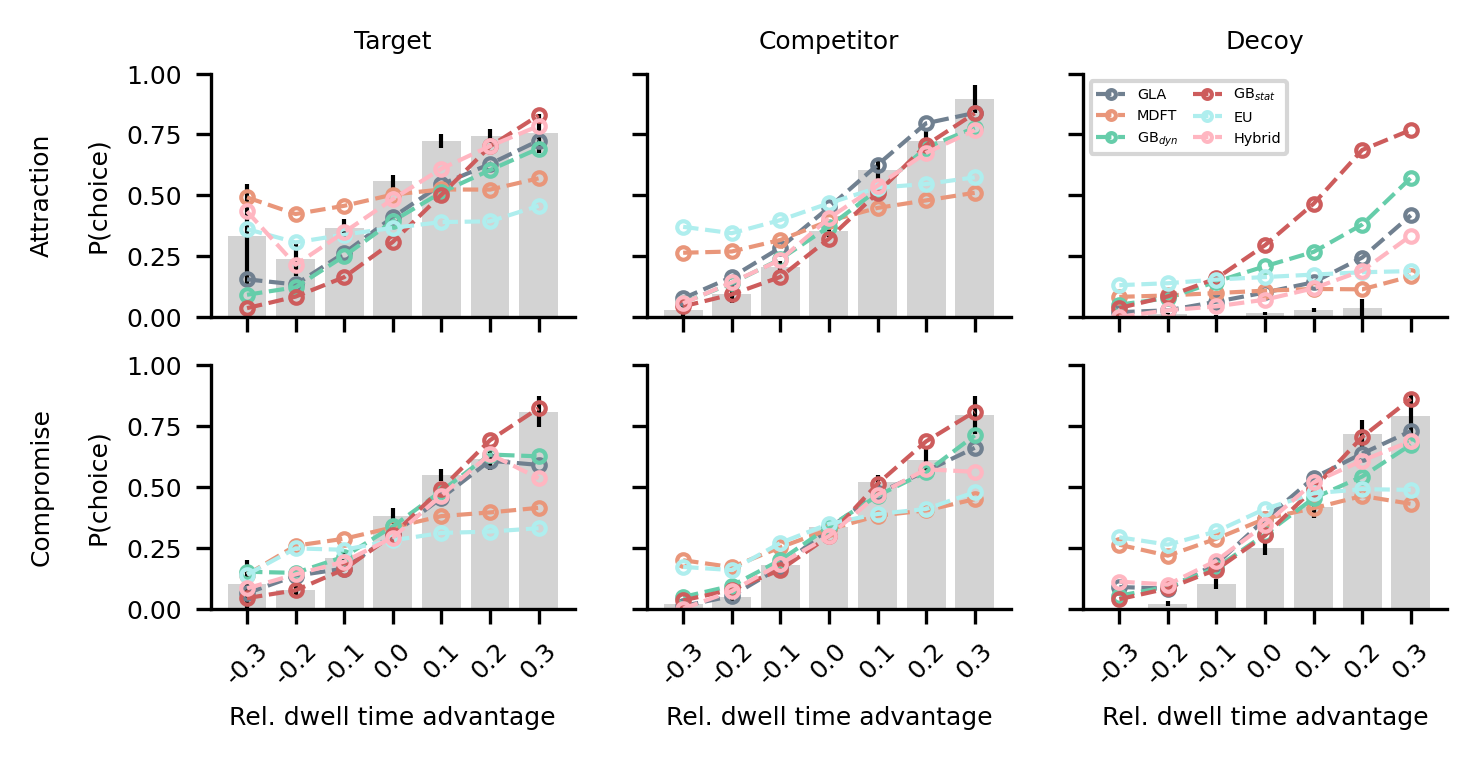

In [7]:
fig, axs = plt.subplots(2, 3, figsize=cm2inch(3 * 4.5, 6), sharey="row", sharex="col")
for e, effect in enumerate(["attraction", "compromise"]):
    for i, alternative in enumerate(["target", "competitor", "decoy"]):
        ax = axs[e, i]
        ax, summary = plot_dwell_adv(
            trials.loc[(trials["effect"] == effect) & (trials["trial"] % 2 == 0)],
            kind="bar",
            color="lightgray",
            alternative=alternative,
            choicecol="choice_tcd",
            ax=ax,
        )
        for m, model in enumerate(models):
            ax, summary = plot_dwell_adv(
                predictions.loc[
                    (predictions["model"] == model)
                    & (predictions["effect"] == effect)
                    & (predictions["trial"] % 2 == 1)
                ],
                kind="line",
                color=palette[m],
                choicecol="predicted_choice_tcd",
                alternative=alternative,
                label=model_labels[model],
                ax=ax,
            )
        if i == 0:
            ax.set_ylabel(f"{effect.capitalize()}\n\nP(choice)")
        else:
            ax.set_ylabel(None)

        if e == 0:
            ax.set_title(f"{alternative.capitalize()}")
            ax.set_xlabel(None)
        else:
            ax.set_xlabel("Rel. dwell time advantage")
legend = axs[0, -1].legend(
    fontsize="xx-small", ncol=2, markerscale=0.7, columnspacing=1
)
plt.savefig(
    join(OUTPUT_DIR, f"dwell-time-advantage_obs_pred_all-models.pdf"),
    bbox_inches="tight",
)

# without strong AE responders

In [8]:
def calc_rst(df, effect="attraction"):
    """Calculate RST.
    
    Parameters
    ----------
    df : pandas.DataFrame
        trial DataFrame, containing columns `subject`, `effect`, `choice_tcd`
    effect : str, one of ['attraction', 'compromise'], optional
        which effect to look at, by default 'attraction'
    
    Returns
    -------
    pandas.Series
        subject-wise RSTs
    """
    cs = (
        df.loc[df["effect"] == effect]
        .groupby("subject")["choice_tcd"]
        .value_counts()
        .rename("frequency")
        .reset_index()
        .pivot_table(index="subject", values="frequency", columns="choice_tcd")
        .fillna(0)
    )
    cs["rst"] = cs["target"] / (cs["target"] + cs["competitor"])
    return cs["rst"]

In [9]:
rst_obs = calc_rst(trials, effect="attraction")
strong_responders = rst_obs.index[rst_obs > 0.7]
strong_responders

Int64Index([0, 5, 7, 14, 19, 22, 32, 35, 42], dtype='int64', name='subject')

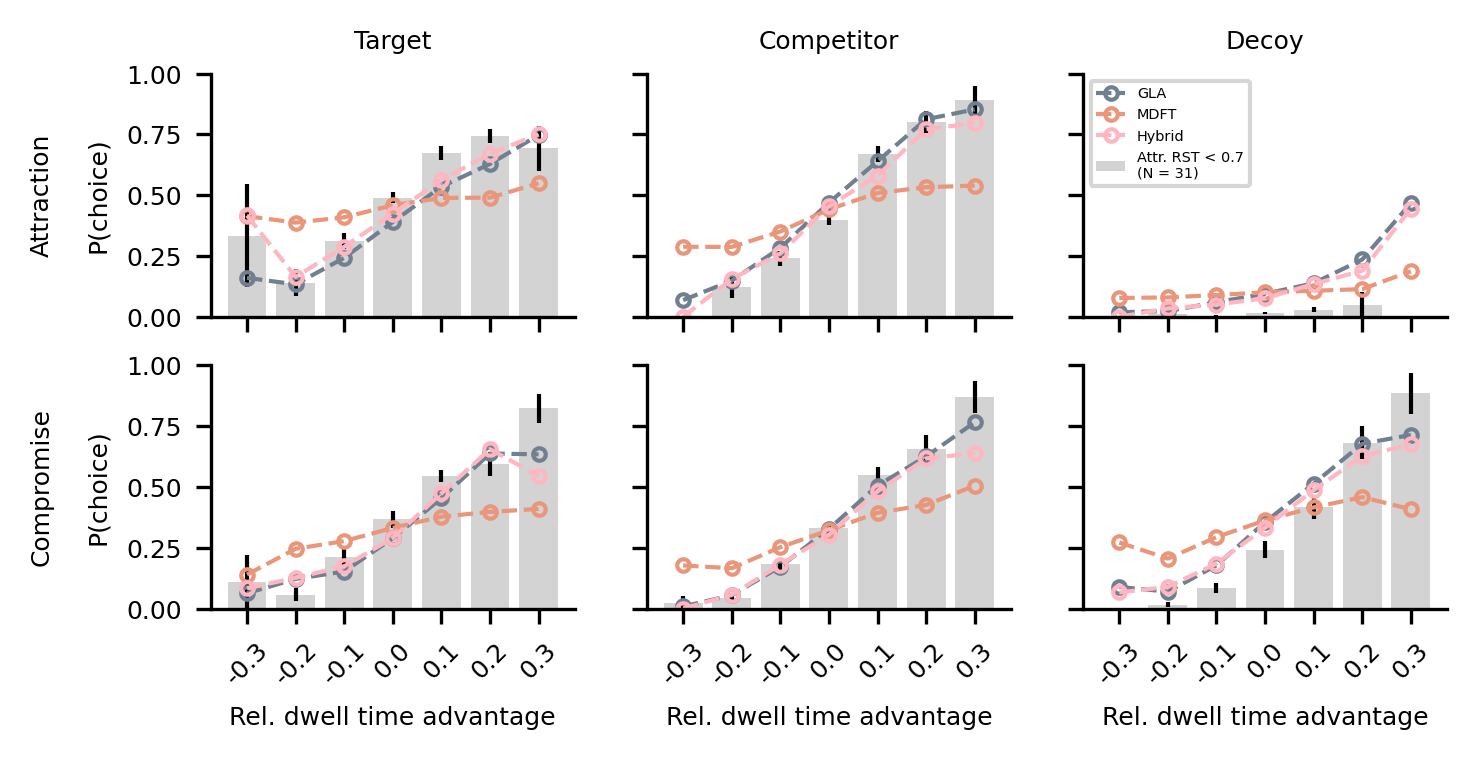

In [10]:
N = len(trials["subject"].unique()) - len(strong_responders)

fig, axs = plt.subplots(2, 3, figsize=cm2inch(3 * 4.5, 6), sharey="row", sharex="col")
for e, effect in enumerate(["attraction", "compromise"]):
    for i, alternative in enumerate(["target", "competitor", "decoy"]):
        ax = axs[e, i]
        ax, summary = plot_dwell_adv(
            trials.loc[
                (trials["effect"] == effect)
                & (~trials["subject"].isin(strong_responders))
                & (trials["trial"] % 2 == 0)
            ],
            kind="bar",
            color="lightgray",
            alternative=alternative,
            choicecol="choice_tcd",
            ax=ax,
            label=f"Attr. RST < 0.7\n(N = {N})",
        )

        for m, model in enumerate(["glickman1layer", "mdft", hybrid]):
            if model == hybrid:
                color = palette[len(models) - 1]
            else:
                color = palette[m]
            ax, summary = plot_dwell_adv(
                predictions.loc[
                    (predictions["model"] == model)
                    & (predictions["effect"] == effect)
                    & (~predictions["subject"].isin(strong_responders))
                    & (predictions["trial"] % 2 == 1)
                ],
                kind="line",
                color=color,
                choicecol="predicted_choice_tcd",
                alternative=alternative,
                label=model_labels[model],
                ax=ax,
            )
        if i == 0:
            ax.set_ylabel(f"{effect.capitalize()}\n\nP(choice)")
        else:
            ax.set_ylabel(None)

        if e == 0:
            ax.set_title(f"{alternative.capitalize()}")
            ax.set_xlabel(None)
        else:
            ax.set_xlabel("Rel. dwell time advantage")
axs[0, -1].legend(fontsize="xx-small", loc="upper left")
plt.savefig(
    join(OUTPUT_DIR, f"dwell-time-advantage_obs_pred_selected-models_ex-strong-ae.pdf"),
    bbox_inches="tight",
)

# only strong AE responders

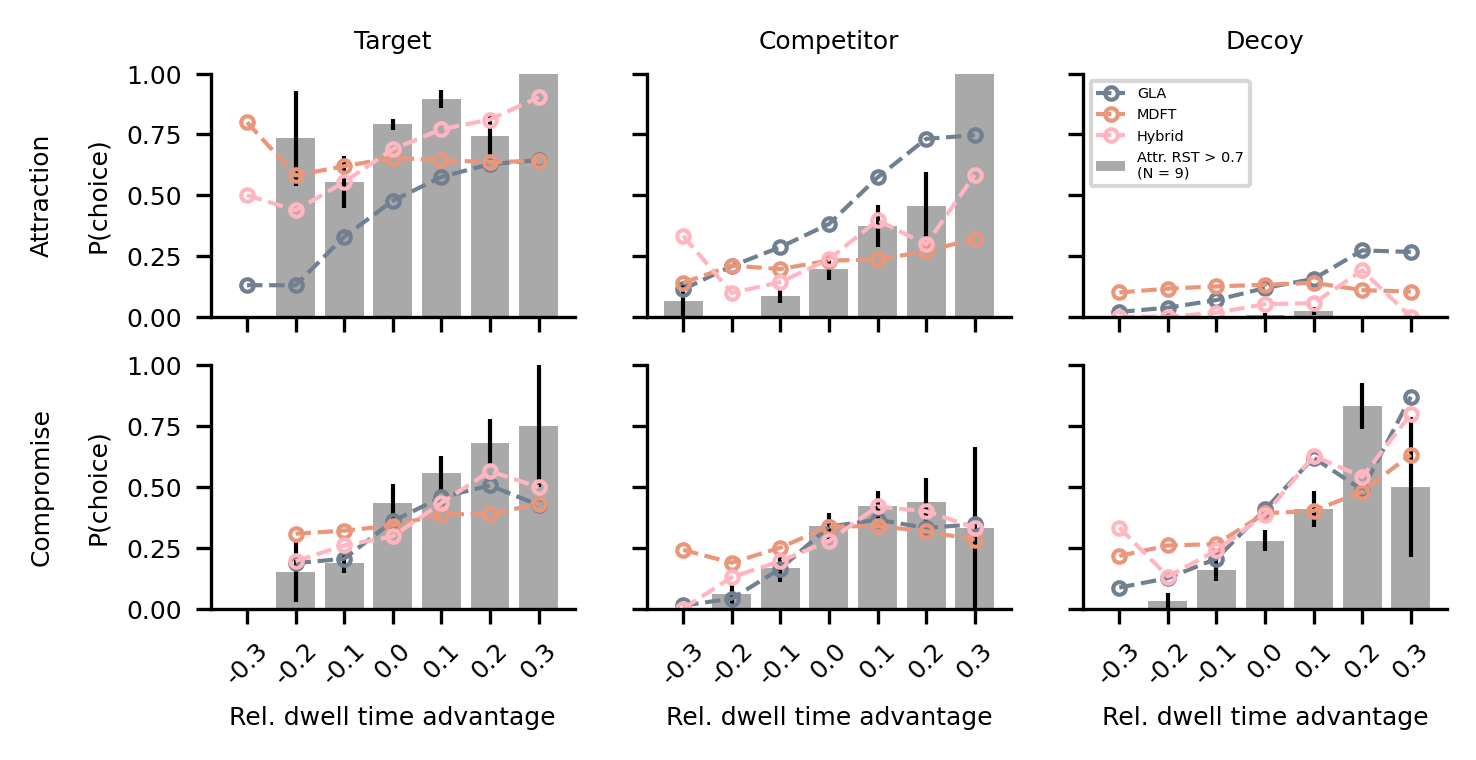

In [11]:
N = len(strong_responders)

fig, axs = plt.subplots(2, 3, figsize=cm2inch(3 * 4.5, 6), sharey="row", sharex="col")
for e, effect in enumerate(["attraction", "compromise"]):
    for i, alternative in enumerate(["target", "competitor", "decoy"]):
        ax = axs[e, i]
        ax, summary = plot_dwell_adv(
            trials.loc[
                (trials["effect"] == effect)
                & (trials["subject"].isin(strong_responders))
                & (trials["trial"] % 2 == 0)
            ],
            kind="bar",
            color="darkgray",
            alternative=alternative,
            choicecol="choice_tcd",
            ax=ax,
            label=f"Attr. RST > 0.7\n(N = {N})",
        )

        for m, model in enumerate(["glickman1layer", "mdft", hybrid]):
            if model == hybrid:
                color = palette[len(models) - 1]
            else:
                color = palette[m]
            ax, summary = plot_dwell_adv(
                predictions.loc[
                    (predictions["model"] == model)
                    & (predictions["effect"] == effect)
                    & (predictions["subject"].isin(strong_responders))
                    & (predictions["trial"] % 2 == 1)
                ],
                kind="line",
                color=color,
                choicecol="predicted_choice_tcd",
                alternative=alternative,
                label=model_labels[model],
                ax=ax,
            )
        if i == 0:
            ax.set_ylabel(f"{effect.capitalize()}\n\nP(choice)")
        else:
            ax.set_ylabel(None)

        if e == 0:
            ax.set_title(f"{alternative.capitalize()}")
            ax.set_xlabel(None)
        else:
            ax.set_xlabel("Rel. dwell time advantage")
axs[0, -1].legend(fontsize="xx-small", loc="upper left")
plt.savefig(
    join(
        OUTPUT_DIR, f"dwell-time-advantage_obs_pred_selected-models_only-strong-ae.pdf"
    ),
    bbox_inches="tight",
)